In [2]:
!python -m spacy download en_core_web_lg

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [47]:
import en_core_web_lg
import pandas as pd
import re
import random
import spacy
from spacy.util import minibatch, compounding
import warnings
import matplotlib.pyplot as plt
import nltk
import numpy as np

In [8]:
food_df = pd.read_csv("food.csv")

In [9]:
food_df.head()

,fdc_id,data_type,description,food_category_id,publication_date
0,1105904,branded_food,WESSON Vegetable Oil 1 GAL,NaN,2020-11-13
1,1105905,branded_food,SWANSON BROTH BEEF,NaN,2020-11-13
2,1105906,branded_food,CAMPBELL'S SLOW KETTLE SOUP CLAM CHOWDER,NaN,2020-11-13
3,1105907,branded_food,CAMPBELL'S SLOW KETTLE SOUP CHEESE BROCCOLI,NaN,2020-11-13
4,1105898,experimental_food,Discrepancy between the Atwater factor predict...,NaN,2020-10-30


In [10]:
food_df["description"].size

1605401

In [11]:
# diaqualify foods with special characters, lowercase and extract results from "description" column
foods = food_df[food_df["description"].str.contains("[^a-zA-Z ]") == False]["description"].apply(lambda food: food.lower())

# filter out foods with more than 3 words, drop any duplicates
foods = foods[foods.str.split().apply(len) <= 3].drop_duplicates()

# print the remaining size
foods.size

41363

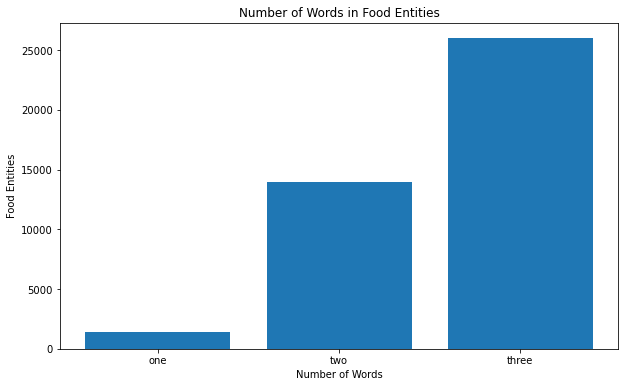

In [12]:
# find one-worded, two-worded and three-worded foods
one_worded_foods = foods[foods.str.split().apply(len) == 1]
two_worded_foods = foods[foods.str.split().apply(len) == 2]
three_worded_foods = foods[foods.str.split().apply(len) == 3]

# create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([1, 2, 3], [one_worded_foods.size, two_worded_foods.size, three_worded_foods.size])

# label the x-axis instances
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["one", "two", "three"])

# set the title and the xy-axis labels
plt.title("Number of Words in Food Entities")
plt.xlabel("Number of Words")
plt.ylabel("Food Entities")

# display the plot
plt.show()

In [13]:
# total number of foods
total_num_foods = round(one_worded_foods.size / 45 * 100)

# shuffle the 2-worded and 3-worded foods since we'll be slicing them
two_worded_foods = two_worded_foods.sample(frac=1)
three_worded_foods = three_worded_foods.sample(frac=1)

# append the foods together 
foods = one_worded_foods.append(two_worded_foods[:round(total_num_foods * 0.30)]).append(three_worded_foods[:round(total_num_foods * 0.25)])

# print the resulting sizes
for i in range(3):
    print(f"{i+1}-worded food entities:", foods[foods.str.split().apply(len) == i + 1].size)

1-worded food entities: 1443
2-worded food entities: 962
3-worded food entities: 802


In [14]:
food_templates = [
    "I ate my {}",
    "I'm eating a {}",
    "I just ate a {}",
    "I only ate the {}",
    "I'm done eating a {}",
    "I've already eaten a {}",
    "I just finished my {}",
    "When I was having lunch I ate a {}",
    "I had a {} and a {} today",
    "I ate a {} and a {} for lunch",
    "I made a {} and {} for lunch",
    "I ate {} and {}",
    "today I ate a {} and a {} for lunch",
    "I had {} with my husband last night",
    "I brought you some {} on my birthday",
    "I made {} for yesterday's dinner",
    "last night, a {} was sent to me with {}",
    "I had {} yesterday and I'd like to eat it anyway",
    "I ate a couple of {} last night",
    "I had some {} at dinner last night",
    "Last night, I ordered some {}",
    "I made a {} last night",
    "I had a bowl of {} with {} and I wanted to go to the mall today",
    "I brought a basket of {} for breakfast this morning",
    "I had a bowl of {}",
    "I ate a {} with {} in the morning",
    "I made a bowl of {} for my breakfast",
    "There's {} for breakfast in the bowl this morning",
    "This morning, I made a bowl of {}",
    "I decided to have some {} as a little bonus",
    "I decided to enjoy some {}",
    "I've decided to have some {} for dessert",
    "I had a {}, a {} and {} at home",
    "I took a {}, {} and {} on the weekend",
    "I ate a {} with {} and {} just now",
    "Last night, I ate an {} with {} and {}",
    "I tasted some {}, {} and {} at the office",
    "There's a basket of {}, {} and {} that I consumed",
    "I devoured a {}, {} and {}",
    "I've already had a bag of {}, {} and {} from the fridge",
    "{} is delicious",
    "{} is great"
]

In [15]:
TRAIN_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

TEST_FOOD_DATA = {
    "one_food": [],
    "two_foods": [],
    "three_foods": []
}

# one_food, two_food, and three_food combinations will be limited to 167 sentences
FOOD_SENTENCE_LIMIT = 167

# helper function for deciding what dictionary and subsequent array to append the food sentence on to
def get_food_data(count):
    return {
        1: TRAIN_FOOD_DATA["one_food"] if len(TRAIN_FOOD_DATA["one_food"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["one_food"],
        2: TRAIN_FOOD_DATA["two_foods"] if len(TRAIN_FOOD_DATA["two_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["two_foods"],
        3: TRAIN_FOOD_DATA["three_foods"] if len(TRAIN_FOOD_DATA["three_foods"]) < FOOD_SENTENCE_LIMIT else TEST_FOOD_DATA["three_foods"],
    }[count]

# the pattern to replace from the template sentences
pattern_to_replace = "{}"

# shuffle the data before starting
foods = foods.sample(frac=1)

# the count that helps us decide when to break from the for loop
food_entity_count = foods.size - 1

# start the while loop, ensure we don't get an index out of bounds error
while food_entity_count >= 2:
    entities = []

    # pick a random food template
    sentence = food_templates[random.randint(0, len(food_templates) - 1)]

    # find out how many braces "{}" need to be replaced in the template
    matches = re.findall(pattern_to_replace, sentence)

    # for each brace, replace with a food entity from the shuffled food data
    for match in matches:
        food = foods.iloc[food_entity_count]
        food_entity_count -= 1

        # replace the pattern, but then find the match of the food entity we just inserted
        sentence = sentence.replace(match, food, 1)
        match_span = re.search(food, sentence).span()

        # use that match to find the index positions of the food entity in the sentence, append
        entities.append((match_span[0], match_span[1], "FOOD"))

    # append the sentence and the position of the entities to the correct dictionary and array
    get_food_data(len(matches)).append((sentence, {"entities": entities}))

In [16]:
for key in TRAIN_FOOD_DATA:
    print("{} {} sentences: {}".format(len(TRAIN_FOOD_DATA[key]), key, TRAIN_FOOD_DATA[key][0]))

167 one_food sentences: ("I've already eaten a pastel pink sixlets", {'entities': [(21, 40, 'FOOD')]})
167 two_foods sentences: ('I ate a crisp granola and a mackerel fillets for lunch', {'entities': [(8, 21, 'FOOD'), (28, 44, 'FOOD')]})
167 three_foods sentences: ('Last night, I ate an pasta trpina rigatoni with edam and chocolate eclair bar', {'entities': [(21, 42, 'FOOD'), (48, 52, 'FOOD'), (57, 77, 'FOOD')]})


In [17]:
for key in TEST_FOOD_DATA:
    print("{} {} items: {}".format(len(TEST_FOOD_DATA[key]), key, TEST_FOOD_DATA[key][0]))

1117 one_food items: ("I'm eating a carne guisada", {'entities': [(13, 26, 'FOOD')]})
213 two_foods items: ('I had a bowl of waffles  with mixed herbs and I wanted to go to the mall today', {'entities': [(16, 24, 'FOOD'), (30, 41, 'FOOD')]})
220 three_foods items: ('I ate a flan with deli onion rye and pasta zero just now', {'entities': [(8, 12, 'FOOD'), (18, 32, 'FOOD'), (37, 47, 'FOOD')]})


In [69]:
ner_df_1 = pd.read_csv("learn-ai-bbc/BBC News Train.csv")[["Text"]]
ner_df_2 = pd.read_csv("learn-ai-bbc/BBC News Test.csv")[["Text"]]

In [77]:
ner_df = pd.concat([ner_df_1, ner_df_2])
ner_df.columns = [["Article"]]
ner_df.head()

,Article
0,worldcom ex-boss launches defence lawyers defe...
1,german business confidence slides german busin...
2,bbc poll indicates economic gloom citizens in ...
3,lifestyle governs mobile choice faster bett...
4,enron bosses in $168m payout eighteen former e...


In [80]:
npr_df = pd.DataFrame(ner_df.apply(lambda x: x.values[0], axis=1), columns=['Article'])
npr_df.head()

,Article
0,worldcom ex-boss launches defence lawyers defe...
1,german business confidence slides german busin...
2,bbc poll indicates economic gloom citizens in ...
3,lifestyle governs mobile choice faster bett...
4,enron bosses in $168m payout eighteen former e...


In [1]:
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    '''
    Preprocess a string.
    :parameter
        :param text: string - name of column containing text
        :param lst_stopwords: list - list of stopwords to remove
        :param flg_stemm: bool - whether stemming is to be applied
        :param flg_lemm: bool - whether lemmitisation is to be applied
    :return
        cleaned text
    '''
    ## clean (convert to lowercase and remove punctuations and   
    # characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [75]:
nlp = en_core_web_lg.load()

In [89]:
revision_texts = []

# convert the articles to spacy objects to better identify the sentences. Disabled unneeded components. # takes ~ 4 minutes
for doc in nlp.pipe(npr_df["Article"], batch_size=30, disable=["tagger", "ner"]):
    for sentence in doc.sents:
        if  40 < len(sentence.text) < 200:
            # some of the sentences had excessive whitespace in between words, so we're trimming that
            revision_texts.append(" ".join(re.split("\s+", sentence.text, flags=re.UNICODE)))

F:\anaconda3\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [90]:
len(revision_texts)

37143

In [91]:
revisions = []

# Use the existing spaCy model to predict the entities, then append them to revision
for doc in nlp.pipe(revision_texts, batch_size=50, disable=["tagger", "parser"]):
    
    # don't append sentences that have no entities
    if len(doc.ents) > 0:
        revisions.append((doc.text, {"entities": [(e.start_char, e.end_char, e.label_) for e in doc.ents]}))

F:\anaconda3\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [92]:
# print an example of the revision sentence
print(revisions[0][0])

# print an example of the revision data
print(revisions[0][1])

worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.
{'entities': [(0, 8, 'ORG'), (59, 67, 'ORG'), (74, 80, 'PERSON'), (168, 173, 'ORDINAL')]}


In [93]:
# create arrays to store the revision data
TRAIN_REVISION_DATA = []
TEST_REVISION_DATA = []

# create dictionaries to keep count of the different entities
TRAIN_ENTITY_COUNTER = {}
TEST_ENTITY_COUNTER = {}

# This will help distribute the entities (i.e. we don't want 1000 PERSON entities, but only 80 ORG entities)
REVISION_SENTENCE_SOFT_LIMIT = 100

# helper function for incrementing the revision counters
def increment_revision_counters(entity_counter, entities):
    for entity in entities:
        label = entity[2]
        if label in entity_counter:
            entity_counter[label] += 1
        else:
            entity_counter[label] = 1

random.shuffle(revisions)
for revision in revisions:
    # get the entities from the revision sentence
    entities = revision[1]["entities"]

    # simple hack to make sure spaCy entities don't get too one-sided
    should_append_to_train_counter = 0
    for _, _, label in entities:
        if label in TRAIN_ENTITY_COUNTER and TRAIN_ENTITY_COUNTER[label] > REVISION_SENTENCE_SOFT_LIMIT:
            should_append_to_train_counter -= 1
        else:
            should_append_to_train_counter += 1

    # simple switch for deciding whether to append to train data or test data
    if should_append_to_train_counter >= 0:
        TRAIN_REVISION_DATA.append(revision)
        increment_revision_counters(TRAIN_ENTITY_COUNTER, entities)
    else:
        TEST_REVISION_DATA.append(revision)
        increment_revision_counters(TEST_ENTITY_COUNTER, entities)

In [94]:
# combine the food training data
TRAIN_FOOD_DATA_COMBINED = TRAIN_FOOD_DATA["one_food"] + TRAIN_FOOD_DATA["two_foods"] + TRAIN_FOOD_DATA["three_foods"]

# print the length of the food training data
print("FOOD", len(TRAIN_FOOD_DATA_COMBINED))

# print the length of the revision training data
print("REVISION", len(TRAIN_REVISION_DATA))

# join and print the combined length
TRAIN_DATA = TRAIN_REVISION_DATA + TRAIN_FOOD_DATA_COMBINED
print("COMBINED", len(TRAIN_DATA))

FOOD 501
REVISION 1018
COMBINED 1519


In [97]:
ner = nlp.get_pipe("ner")
ner.add_label("FOOD")
from spacy.training import Example

# get the names of the components we want to disable during training
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# start the training loop, only training NER
epochs = 30
optimizer = nlp.resume_training()
with nlp.disable_pipes(*other_pipes), warnings.catch_warnings():
    warnings.filterwarnings("once", category=UserWarning, module='spacy')
    sizes = compounding(1.0, 4.0, 1.001)
    
    # batch up the examples using spaCy's minibatc
    for epoch in range(epochs):
        examples = TRAIN_DATA
        random.shuffle(examples)
        batches = minibatch(examples, size=sizes)
        losses = {}
        
        for batch in batches:
            texts, annotations = zip(*batch)
            example = []
        # Update the model with iterating each text
            for i in range(len(texts)):
                doc = nlp.make_doc(texts[i])
                example.append(Example.from_dict(doc, annotations[i]))
        
            nlp.update(example, sgd=optimizer, drop=0.35, losses=losses)

        print("Losses ({}/{})".format(epoch + 1, epochs), losses)

F:\anaconda3\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "I ate a sour gummi santas with applesauce  and ita..." with entities "[(8, 25, 'FOOD'), (31, 42, 'FOOD'), (47, 66, 'FOOD...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
F:\anaconda3\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "I've decided to have some stewed tomatoes  for des..." with entities "[(26, 42, 'FOOD')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
F:\anaconda3\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning: [W030] Some entities could not be aligned in the text "I had a apples , a potato sticks and stuf

Losses (1/30) {'ner': 2696.560790725156}
Losses (2/30) {'ner': 1700.5449324950175}
Losses (3/30) {'ner': 1376.1217372468611}
Losses (4/30) {'ner': 1206.2528038390888}
Losses (5/30) {'ner': 1133.768218684352}
Losses (6/30) {'ner': 941.3115645749045}
Losses (7/30) {'ner': 957.0509242290414}
Losses (8/30) {'ner': 833.8071583984771}
Losses (9/30) {'ner': 820.4601613202711}
Losses (10/30) {'ner': 815.6817262677974}
Losses (11/30) {'ner': 736.282218189483}
Losses (12/30) {'ner': 701.9625430330875}
Losses (13/30) {'ner': 717.2771084666373}
Losses (14/30) {'ner': 616.3865549564459}
Losses (15/30) {'ner': 628.703534421355}
Losses (16/30) {'ner': 554.7165739578395}
Losses (17/30) {'ner': 635.7095733933234}
Losses (18/30) {'ner': 516.003822191571}
Losses (19/30) {'ner': 507.82512237553743}
Losses (20/30) {'ner': 554.1818542134298}
Losses (21/30) {'ner': 456.1951370228754}
Losses (22/30) {'ner': 469.80061714713736}
Losses (23/30) {'ner': 401.00576111448726}
Losses (24/30) {'ner': 397.909995311683}

In [99]:
spacy.displacy.render(nlp("I had a hamburger and chips for lunch today."), style="ent")
spacy.displacy.render(nlp("I decided to have chocolate ice cream as a little treat for myself."), style="ent")
spacy.displacy.render(nlp("I ordered basmati rice, leaf spinach and cheese from Tesco yesterday"), style="ent")

In [100]:
# dictionary to hold our evaluation data
food_evaluation = {
    "one_food": {
        "correct": 0,
        "total": 0,
    },
    "two_foods": {
        "correct": 0,
        "total": 0
    },
    "three_foods": {
        "correct": 0,
        "total": 0
    }
}

word_evaluation = {
    "1_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "2_worded_foods": {
        "correct": 0,
        "total": 0
    },
    "3_worded_foods": {
        "correct": 0,
        "total": 0
    }
}

# loop over data from our test food set (3 keys in total)
for key in TEST_FOOD_DATA:
    foods = TEST_FOOD_DATA[key]

    for food in foods:
        # extract the sentence and correct food entities according to our test data
        sentence = food[0]
        entities = food[1]["entities"]

        # for each entity, use our updated model to make a prediction on the sentence
        for entity in entities:
            doc = nlp(sentence)
            correct_text = sentence[entity[0]:entity[1]]
            n_worded_food =  len(correct_text.split())

            # if we find that there's a match for predicted entity and predicted text, increment correct counters
            for ent in doc.ents:
                if ent.label_ == entity[2] and ent.text == correct_text:
                    food_evaluation[key]["correct"] += 1
                    if n_worded_food > 0:
                        word_evaluation[f"{n_worded_food}_worded_foods"]["correct"] += 1
                    
                    # this break is important, ensures that we're not double counting on a correct match
                    break
            
            #  increment total counters after each entity loop
            food_evaluation[key]["total"] += 1
            if n_worded_food > 0:
                word_evaluation[f"{n_worded_food}_worded_foods"]["total"] += 1

In [101]:
for key in word_evaluation:
    correct = word_evaluation[key]["correct"]
    total = word_evaluation[key]["total"]

    print(f"{key}: {correct / total * 100:.2f}%")

food_total_sum = 0
food_correct_sum = 0

print("---")
for key in food_evaluation:
    correct = food_evaluation[key]["correct"]
    total = food_evaluation[key]["total"]
    
    food_total_sum += total
    food_correct_sum += correct

    print(f"{key}: {correct / total * 100:.2f}%")

print(f"\nTotal: {food_correct_sum/food_total_sum * 100:.2f}%")

1_worded_foods: 95.02%
2_worded_foods: 96.51%
3_worded_foods: 96.01%
---
one_food: 95.17%
two_foods: 94.84%
three_foods: 97.27%

Total: 95.73%


In [102]:
# dictionary which will be populated with the entities and result information
entity_evaluation = {}

# helper function to udpate the entity_evaluation dictionary
def update_results(entity, metric):
    if entity not in entity_evaluation:
        entity_evaluation[entity] = {"correct": 0, "total": 0}
    
    entity_evaluation[entity][metric] += 1

# same as before, see if entities from test set match what spaCy currently predicts
for data in TEST_REVISION_DATA:
    sentence = data[0]
    entities = data[1]["entities"]

    for entity in entities:
        doc = nlp(sentence)
        correct_text = sentence[entity[0]:entity[1]]

        for ent in doc.ents:
            if ent.label_ == entity[2] and ent.text == correct_text:
                update_results(ent.label_, "correct")
                break

        update_results(entity[2], "total")

In [103]:
sum_total = 0
sum_correct = 0

for entity in entity_evaluation:
    total = entity_evaluation[entity]["total"]
    correct = entity_evaluation[entity]["correct"]

    sum_total += total
    sum_correct += correct
    
    print("{} | {:.2f}%".format(entity, correct / total * 100))

print()
print("Overall accuracy: {:.2f}%".format(sum_correct / sum_total * 100))

DATE | 83.22%
ORG | 46.17%
GPE | 75.52%
PERSON | 66.10%
ORDINAL | 90.80%
CARDINAL | 65.76%
NORP | 92.39%
PERCENT | 94.33%
EVENT | 73.73%
MONEY | 86.57%
QUANTITY | 77.38%
PRODUCT | 54.17%
TIME | 77.73%
FAC | 60.42%
LOC | 82.69%
WORK_OF_ART | 33.33%
LAW | 65.52%
LANGUAGE | 81.25%

Overall accuracy: 72.71%


In [104]:
import joblib
joblib.dump(nlp, 'my_trained_model.pkl', compress=9)

['my_trained_model.pkl']